In [1]:
from pyfiles.nonftsteane import *

In [30]:
qc = code_goto()

H_L(qc, 0)
#qec(qc, 0)
##T_L(qc, 0)
#CNOT_L(qc,0)
#qec(qc, 0)
H_L(qc, 1)

zeros, ones, pre , post = readout(qc, 1, 1000, 0.00)

print("Preselection discarded: ", pre*100, "%")
print("Postselection discarded: ", post*100, "%")
print("Accepted 0: ", zeros*100, "%")
print("Accepted 1: ", ones*100, "%")
print("Total discarded: ", (pre+post)*100, "%")
print("Succesrate: ", zeros/(ones+zeros))

Preselection discarded:  0.0 %
Postselection discarded:  0.0 %
Accepted 0:  48.3 %
Accepted 1:  51.7 %
Total discarded:  0.0 %
Succesrate:  0.483


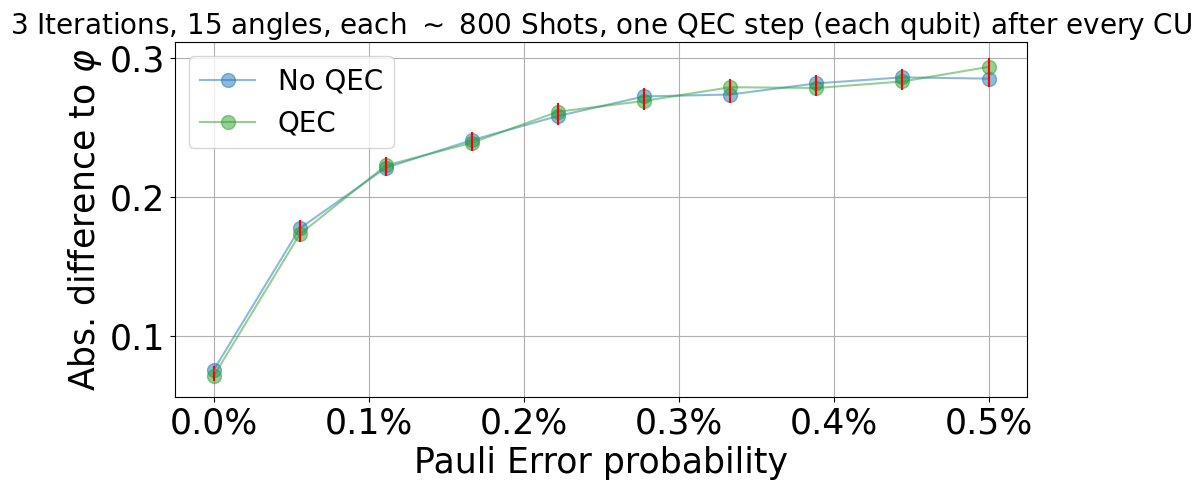

In [3]:
x, y, y_qec, err, err_qec = np.loadtxt("HPC/text/nonFTSteane_j.txt", delimiter = ",")          #QEC after every third T/Tdg

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 1))

err = [i/((100)**0.5) for i in err]
err_qec = [i/((100)**0.5)for i in err_qec]


ax1.plot(x,y, label="No QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y, yerr=err, ecolor="red", linestyle="")

ax1.plot(x,y_qec, label="QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y_qec, yerr=err_qec, ecolor="red", linestyle="")

ax1.set_title(r"3 Iterations, 15 angles, each $\sim$ 800 Shots, one QEC step (each qubit) after every CU", fontsize=20)

ax1.set_xlabel("Pauli Error probability", fontsize=25)

ax1.set_ylabel(r"Abs. difference to $\varphi$", fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=25)

ax1.grid()
ax1.legend(fontsize=20)

#fig.suptitle('Three iterations iQPE on a [12,2,4] Carbon Code', fontsize=20)
plt.tight_layout()
#plt.savefig("Figures/SteaneFinal3.png", dpi = 200)
plt.show()

In [2]:
def avg15_coin(iter: int, n:int, noise: float, err = False, k = 1):       #each iteration own circuit
    angle = np.linspace(0,1,n+2)
    angle = np.delete(angle, [n+1])
    angle = np.delete(angle, [0])

    a, b = [], []
    with open("HPC/Upload/unitary{}.txt".format(n), "r") as file:
        for line in file:
            a.append(list(map(str, line.strip().split(","))))
    with open("HPC/Upload/adjunitary{}.txt".format(n), "r") as file:
        for line in file:
            b.append(list(map(str, line.strip().split(","))))
    
    y = 0
    bruh1 = []
    #for m in range(k):
    for o in range(n):
        bitstring = ""
        rots = []
        for t in range(iter):
            rots = [k*0.5 for k in rots]
            qc = code_goto()

            X_L(qc,1)
            H_L(qc,0)
            #############################
            for j in range(2**(iter-t-1)):
                CU_L(qc, a[o], b[o])
                if err:
                    qec(qc, 0)
                    qec(qc, 1)
            ###############################
            for l in rots:
                if l == 0.25:
                    adj_S_L(qc, pos=0)
                if l == 0.125:
                    adj_T_L(qc, pos=0)
            H_L(qc, pos=0)
            if err:
                qec(qc, 0)
            zeros, ones, pre, post = readout(qc, pos=0, shots=k, noise=noise)

            # print("Zeros: ", zeros)
            # print("Ones: ", ones)
            # print("Pre: ", pre)
            # print("Post: ", post)

            if zeros == 1:
                bitstring += "0"
            elif ones == 1:
                bitstring += "1"
                rots.append(0.5)
            else:
                if np.random.rand() < 0.5:
                    bitstring += "0"
                else:
                    bitstring += "1"
                    rots.append(0.5)
        #print("Bitstring: ", bitstring)
        bitstring = bitstring[::-1]
        hmm = convert(bitstring)
        diff = np.abs(hmm-angle[o])
        y += diff
        bruh1.append(diff)
    y = y/(n*k)
    arg = 0
    for i in range(len(bruh1)):
        arg += (y-bruh1[i])**2
    sigma = ((1/(k*n))*arg)**0.5
    sigma = sigma/((k*n)**0.5)

    return y, sigma

def gen_data(shots: int):
    p = [0.005]
    y, y_qec = [],[]
    err, err_qec = [], []

    for r in p:
        ok, errr = avg15_coin(3, 15, noise=0, err=False, k=shots)
        y.append(ok), err.append(errr)
        ok1, errr1 = avg15_coin(3, 15, noise=0, err=True, k=shots)
        y_qec.append(ok1), err_qec.append(errr1)

    data = np.array((p, y, y_qec, err, err_qec))
    return data

In [3]:
data = gen_data(shots=1)

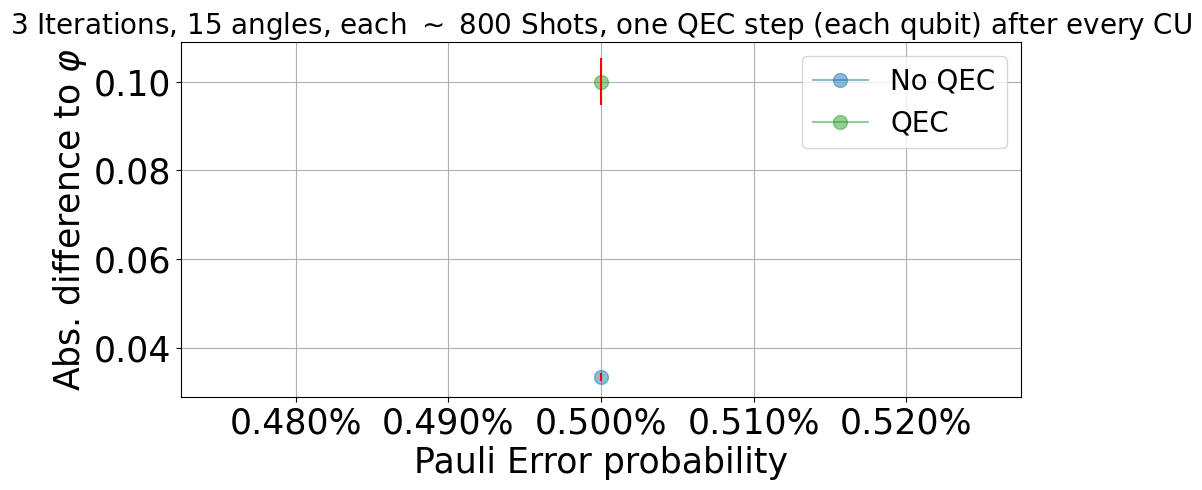

In [4]:
x, y, y_qec, err, err_qec = data         #QEC after every third T/Tdg

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 3))

err = [i/((100)**0.5) for i in err]
err_qec = [i/((100)**0.5)for i in err_qec]


ax1.plot(x,y, label="No QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y, yerr=err, ecolor="red", linestyle="")

ax1.plot(x,y_qec, label="QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y_qec, yerr=err_qec, ecolor="red", linestyle="")

ax1.set_title(r"3 Iterations, 15 angles, each $\sim$ 800 Shots, one QEC step (each qubit) after every CU", fontsize=20)

ax1.set_xlabel("Pauli Error probability", fontsize=25)

ax1.set_ylabel(r"Abs. difference to $\varphi$", fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=25)

ax1.grid()
ax1.legend(fontsize=20)

#fig.suptitle('Three iterations iQPE on a [12,2,4] Carbon Code', fontsize=20)
plt.tight_layout()
#plt.savefig("Figures/SteaneFinal3.png", dpi = 200)
plt.show()